## Домашняя работа 4. 

Максимальный балл за задание - 10.

## Данные


В этой домашней работе мы будем обучать модели машинного обучения, ставить эксперименты, подбирать гиперпараметры, сравнивать и смешивать модели. Вам предлагается решить задачу бинарной классификации, а именно построить алгоритм, определяющий превысит ли средний заработок человека порог $50k. Каждый объект выборки — человек, для которого известны следующие признаки:
 - age
 - workclass
 - fnlwgt
 - education
 - education-num
 - marital-status
 - occupation
 - relationship
 - race
 - sex
 - capital-gain
 - capital-loss
 - hours-per-week
 
Более подробно про признаки можно почитать [здесь](http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names). Целевой признак записан в переменной *>50K,<=50K*.

## Метрика качества

В задании мы будем оценивать качество моделей с помощью метрики AUC-ROC.

## Подбор гиперпараметров модели

В задачах машинного обучения следует различать параметры модели и гиперпараметры (структурные параметры). Обычно параметры модели настраиваются в ходе обучения (например, веса в линейной модели или структура решающего дерева), в то время как гиперпараметры задаются заранее (например, регуляризация в линейной модели или максимальная глубина решающего дерева). Каждая модель обычно имеет множество гиперпараметров, и нет универсальных наборов гиперпараметров, оптимально работающих во всех задачах, для каждой задачи нужно подбирать свой набор.

Для оптимизации гиперпараметров модели часто используют _перебор по сетке (grid search)_: для каждого гиперпараметра выбирается несколько значений, перебираются все комбинации значений и выбирается комбинация, на которой модель показывает лучшее качество (с точки зрения метрики, которая оптимизируется). Однако в этом случае нужно грамотно оценивать построенную модель, а именно делать разбиение на обучающую и тестовую выборку. Есть несколько схем, как это можно реализовать: 

 - Разбить имеющуюся выборку на обучающую и тестовую. В этом случае сравнение большого числа моделей при переборе параметров приводит к ситуации, когда лучшая на тестовой подвыборке модель не сохраняет свои качества на новых данных. Можно сказать, что происходит _переобучение_ на тестовую выборку.
 - Для устранения описанной выше проблемы, можно разбить данные на 3 непересекающихся подвыборки: обучение (`train`), валидация (`validation`) и контроль (`test`). Валидационную подвыборку используют для сравнения моделей, а `test` — для окончательной оценки качества и сравнения семейств моделей с подобранными параметрами.
 - Другой способ сравнения моделей — [кросс-валидация](http://en.wikipedia.org/wiki/Cross-validation_(statistics). Существуют различные схемы кросс-валидации:
  - Leave-One-Out
  - K-Fold
  - Многократное случайное разбиение выборки
  
Кросс-валидация вычислительно затратна, особенно если вы делаете перебор по сетке с очень большим числом комбинации. С учетом конечности времени на выполнение задания, возникает ряд компромиссов: 
  - сетку можно делать более разреженной, перебирая меньше значений каждого параметра; однако, надо не забывать, что в таком случае можно пропустить хорошую комбинацию параметров;
  - кросс-валидацию можно делать с меньшим числом разбиений или фолдов, но в таком случае оценка качества кросс-валидации становится более шумной и увеличивается риск выбрать неоптимальный набор параметров из-за случайности разбиения;
  - параметры можно оптимизировать последовательно (жадно) — один за другим, а не перебирать все комбинации; такая стратегия не всегда приводит к оптимальному набору;
  - перебирать не все комбинации параметров, а небольшое число случайно выбранных.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


## Задание 

Загрузите набор данных *data.adult.csv*. Чтобы лучше понимать, с чем вы работаете/корректно ли вы загрузили данные можно вывести несколько первых строк на экран.

In [2]:
data = pd.read_csv('data.adult.csv') # вводим данные
data.head() # выводим первые 5 строк датасета


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,">50K,<=50K"
0,34,Local-gov,284843,HS-grad,9,Never-married,Farming-fishing,Not-in-family,Black,Male,594,0,60,<=50K
1,40,Private,190290,Some-college,10,Divorced,Sales,Not-in-family,White,Male,0,0,40,<=50K
2,36,Local-gov,177858,Bachelors,13,Married-civ-spouse,Prof-specialty,Own-child,White,Male,0,0,40,<=50K
3,22,Private,184756,Some-college,10,Never-married,Sales,Own-child,White,Female,0,0,30,<=50K
4,47,Private,149700,Bachelors,13,Married-civ-spouse,Tech-support,Husband,White,Male,15024,0,40,>50K


In [3]:
data.shape # смотрим форму датасета

(16280, 14)

Иногда в данных встречаются пропуски. Как задаются пропуски обычно либо прописывается в описании к данным, либо просто на месте пропуска после чтения данных оказывается значение numpy.nan. Более подробно о работе с пропусками в Pandas можно прочитать например [здесь](http://pandas.pydata.org/pandas-docs/stable/missing_data.html). 

В данном датасете пропущенные значения обозначены как "?". 

**Задание 1 (0.5 балла)** Найдите все признаки, имеющие пропущенные значения. Удалите из выборки все объекты с пропусками.

In [4]:
data = data.replace('?', np.nan)
data = data.dropna()



In [5]:
data.shape # Видим что удалили 16280-15347=933 строки

(15347, 14)

Обычно после загрузки датасета всегда необходима его некоторая предобработка. В данном случае она будет заключаться в следующем: 

 - Выделите целевую переменную в отдельную переменную, удалите ее из датасета и преобразуйте к бинарному формату.
 - Обратите внимание, что не все признаки являются вещественными. В начале мы будем работать только с вещественными признаками. Выделите их отдельно.

In [6]:
data['Target'] = data['>50K,<=50K'].map({'<=50K': 0, '>50K': 1}) # добавляем столбец Target, где 0 - <=50K, 1 - >50K
data.iloc[:, -2:].head() # убедились, что замена прошла успешно


,">50K,<=50K",Target
0,<=50K,0
1,<=50K,0
2,<=50K,0
3,<=50K,0
4,>50K,1


In [7]:
data['Target'].value_counts() # смотрим распределение классов

0    11407
1     3940
Name: Target, dtype: int64

In [8]:
data = data.drop(['>50K,<=50K'], axis=1) # удаляем столбец >50K,<=50K


Вещественные признаки:   
age  
fnlwgt  
education-num  
capital-gain  
capital-loss  
hours-per-week

In [9]:
data_continuous = data[['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'Target']] # создаем датасет с непрерывными признаками и целевой переменной
data_continuous.head() # выводим первые 5 строк датасета

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,Target
0,34,284843,9,594,0,60,0
1,40,190290,10,0,0,40,0
2,36,177858,13,0,0,40,0
3,22,184756,10,0,0,30,0
4,47,149700,13,15024,0,40,1


In [10]:
data_continuous.shape # смотрим форму датасета

(15347, 7)

## Обучение классификаторов на вещественных признаках

В данном разделе необходимо будет работать только с вещественными признаками и целевой переменной.

В начале посмотрим как работает подбор параметров по сетке и как влияет на качество разбиение выборки. Сейчас и далее будем рассматривать 5 алгоритмов:
 - [kNN](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
 - [DecisonTree](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)
 - [SGD Linear Classifier](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)
 - [RandomForest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
 - [GradientBoosting](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)

Для начала у первых трёх алгоритмов выберем один гиперпараметр, который будем оптимизировать:
 - kNN — число соседей (*n_neighbors*)
 - DecisonTree — глубина дерева (*max_depth*)
 - SGD Linear Classifier — оптимизируемая функция (*loss*)
 
Остальные параметры оставляйте в значениях по умолчанию. Для подбора гиперпараметров воспользуйтесь перебором по сетке, который реализован в классе [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). В качестве схемы кросс-валидации используйте 5-fold cv, которую можно задать с помощью класса [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html).

**Задание 2 (1 балл)** Для каждого из первых трех алгоритмов подберите оптимальные значения указанных гиперпараметров. Для каждого из этих алгоритмов постройте график среднего качества по кросс-валидации при заданном значении гиперпараметра, на котором также отобразите доверительный интервал [m-std, m+std], где m - среднее, std - стандартное отклонение.

In [11]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

In [48]:
X = data_continuous.drop(['Target'], axis=1) # создаем датасет с признаками
y = data_continuous['Target'] # создаем датасет с целевой переменной

In [49]:
# KNN
param_grid_KNN = {'n_neighbors':np.arange(1, 30)} # # задаём сетку параметра
              
knnmodel = KNeighborsClassifier() # создаем модель

grid_search = GridSearchCV(knnmodel, param_grid_KNN, cv=5, scoring='roc_auc') 

grid_search.fit(X, y) # обучение модели с помощью GridSearchCV который подобрали выше

print("Наилучший параметр:", grid_search.best_params_) # лучший параметр


best_model_KNN_basic = grid_search.best_estimator_ # лучшая модель

Наилучший параметр: {'n_neighbors': 4}


In [50]:
print('Cross Validation средний ROC_AUC:', cross_val_score(best_model_KNN_basic, X, y, cv = 5, scoring='roc_auc').mean())
print('Cross Validation средний accuracy:', cross_val_score(best_model_KNN_basic, X, y, cv = 5, scoring='accuracy').mean())

Cross Validation средний ROC_AUC: 0.6407153603874729
Cross Validation средний accuracy: 0.7716818494920838


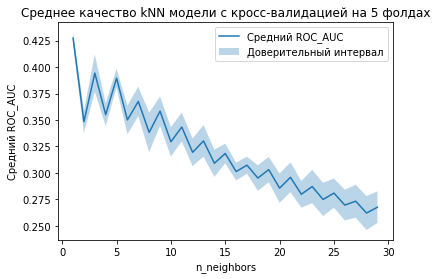

In [51]:
# Строим график для KNN

n_neighbors_values = np.arange(1, 30) # значения параметра n_neighbors

# Создаём пустые списки для средних значений и стандартных отклонений
mean_scores = []
std_scores = []

# Вычисляем средние значения и стандартные отклонения
for n_neighbors in n_neighbors_values:
    knn_model = KNeighborsClassifier(n_neighbors=n_neighbors)
    scores = cross_val_score(knn_model, X, y, cv=5, scoring='roc_auc')
    mean_scores.append(scores.mean())
    std_scores.append(scores.std())

# Подсчитываем границы доверительного интервала
lower_bound = np.array(mean_scores) - np.array(std_scores)
upper_bound = np.array(mean_scores) + np.array(std_scores)

# Строим график
plt.plot(n_neighbors_values, mean_scores, label='Средний ROC_AUC')
plt.fill_between(n_neighbors_values, lower_bound, upper_bound, alpha=0.3, label='Доверительный интервал')
plt.xlabel('n_neighbors')
plt.ylabel('Средний ROC_AUC')
plt.title('Среднее качество kNN модели с кросс-валидацией на 5 фолдах')
plt.legend()
plt.show()


In [52]:
# SGD
param_grid_SGD = {'loss': ['modified_huber', 'epsilon_insensitive', 'squared_epsilon_insensitive', 'hinge', 'huber', 'perceptron', 'squared_hinge', 'log_loss', 'squared_error']} # сетка параметров для SGD
              
sgdmodel = SGDClassifier(max_iter=10000) # создаем модель, max_iter=10000, чтобы не было ошибки, что не успело сойтись решение до определенной итерации

grid_search = GridSearchCV(sgdmodel, param_grid_SGD, cv=5, scoring='roc_auc') # для валидации был выбран f1, так как он учитывает и полноту, и точность. При этом он не учитывает True Negative, что в данном случае нам и не особо важно. Если компании нужно хорошо идентифицировать богатых, то ей может быть важно минимизировать False Negative и False Positive, чтобы найти всех богатых и не тратить время на бедных. Однако конечно выбор метрики зависит от целей. Тут цели туманны, поэтому выбрал такую)

grid_search.fit(X, y) # обучение модели с помощью GridSearchCV который подобрали выше

print("Наилучший параметр:", grid_search.best_params_) # лучший параметр


best_model_sgd = grid_search.best_estimator_ # лучшая модель

Наилучший параметр: {'loss': 'hinge'}


In [53]:
print('Cross Validation средний ROC_AUC:', cross_val_score(best_model_sgd, X, y, cv = 5, scoring='roc_auc').mean())
print('Cross Validation средний accuracy:', cross_val_score(best_model_sgd, X, y, cv = 5, scoring='accuracy').mean())

Cross Validation средний ROC_AUC: 0.6015675059082426
Cross Validation средний accuracy: 0.7729199953724489


/Users/yanik/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/yanik/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/yanik/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/yanik/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/yanik

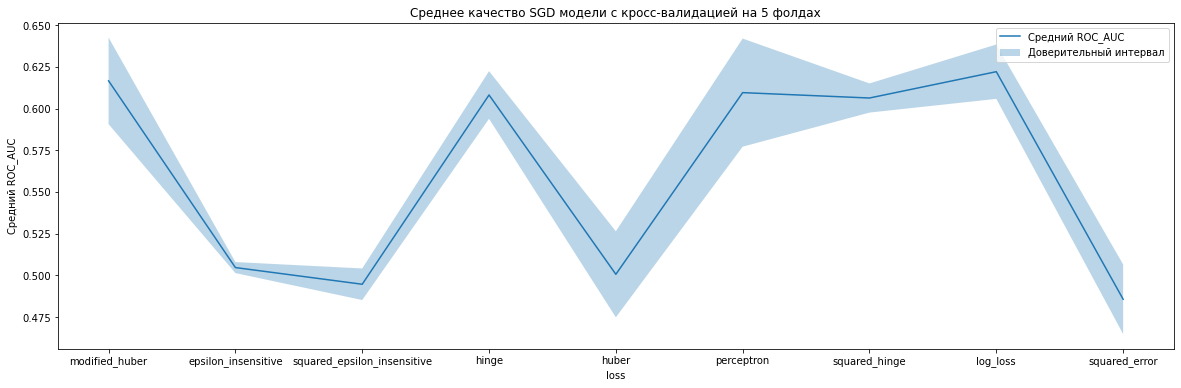

In [54]:
# Строим график для SGD

loss_values = ['modified_huber', 'epsilon_insensitive', 'squared_epsilon_insensitive', 'hinge', 'huber', 'perceptron', 'squared_hinge', 'log_loss', 'squared_error'] # значения параметра loss

# Создаём пустые списки для средних значений и стандартных отклонений
mean_scores = []
std_scores = []

# Вычисляем средние значения и стандартные отклонения
for loss in loss_values:
    sgd_model = SGDClassifier(loss=loss)
    scores = cross_val_score(sgd_model, X, y, cv=5, scoring='roc_auc')
    mean_scores.append(scores.mean())
    std_scores.append(scores.std())

# Подсчитываем границы доверительного интервала
lower_bound = np.array(mean_scores) - np.array(std_scores)
upper_bound = np.array(mean_scores) + np.array(std_scores)

# Строим график
plt.figure(figsize=(20, 6))
plt.plot(loss_values, mean_scores, label='Средний ROC_AUC')
plt.fill_between(loss_values, lower_bound, upper_bound, alpha=0.3, label='Доверительный интервал')
plt.xlabel('loss')
plt.ylabel('Средний ROC_AUC')
plt.title('Среднее качество SGD модели с кросс-валидацией на 5 фолдах')
plt.legend()
plt.show()

In [55]:
# Decision Tree
param_grid_tree = {'max_depth':np.arange(1, 100)} # # задаём сетку параметра
              
treemodel = DecisionTreeClassifier() # создаем модель

grid_search = GridSearchCV(treemodel, param_grid_tree, cv=5, scoring='roc_auc') 

grid_search.fit(X, y) # обучение модели с помощью GridSearchCV который подобрали выше

print("Наилучший параметр:", grid_search.best_params_) # лучший параметр


best_model_tree = grid_search.best_estimator_ # лучшая модель

Наилучший параметр: {'max_depth': 7}


In [56]:
print('Cross Validation средний roc_auc:', cross_val_score(best_model_tree, X, y, cv = 5, scoring='roc_auc').mean())
print('Cross Validation средний accuracy:', cross_val_score(best_model_tree, X, y, cv = 5, scoring='accuracy').mean())

Cross Validation средний roc_auc: 0.8412648154753455
Cross Validation средний accuracy: 0.819118472738311


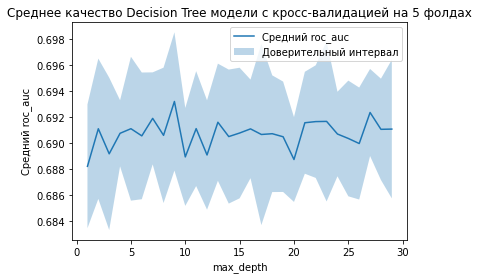

In [57]:
# Строим график для Decision Tree

max_depth_values = np.arange(1, 30) # значения параметра max_depth

# Создаём пустые списки для средних значений и стандартных отклонений
mean_scores = []
std_scores = []

# Вычисляем средние значения и стандартные отклонения
for max_depth in max_depth_values:
    tree_model = DecisionTreeClassifier(max_depth=n_neighbors)
    scores = cross_val_score(tree_model, X, y, cv=5, scoring='roc_auc')
    mean_scores.append(scores.mean())
    std_scores.append(scores.std())

# Подсчитываем границы доверительного интервала
lower_bound = np.array(mean_scores) - np.array(std_scores)
upper_bound = np.array(mean_scores) + np.array(std_scores)

# Строим график
plt.plot(max_depth_values, mean_scores, label='Средний roc_auc')
plt.fill_between(max_depth_values, lower_bound, upper_bound, alpha=0.3, label='Доверительный интервал')
plt.xlabel('max_depth')
plt.ylabel('Средний roc_auc')
plt.title('Среднее качество Decision Tree модели с кросс-валидацией на 5 фолдах')
plt.legend()
plt.show()

Что вы можете сказать о получившихся графиках?

Оговорюсь, что сначала высчитанный наилучший параметр через GridSearch может поменяться в методах SGD и Decision Tree на построенных графиках при разных прогонах. В SGD понятно, в стохастическом градиентном спуске начальная точка для градиентного спуска выбирается случайным образом, и поэтому каждый прогон может привести к немного разным результатам. 

DecisionTreeClassifier также может иметь элемент случайности (например, при выборе признака для разделения при равенстве качества разделения).

KNeighborsClassifier, с другой стороны, не является стохастическим алгоритмом, и он будет давать одни и те же результаты при каждом прогоне, при условии, что тренировочные и тестовые данные остаются неизменными.

KNN
Видно, что модель при увеличении количества соседей начинает показывать более плохие результаты на метрке roc-auc. Это и понятно: Увеличение параметра 'n_neighbors' в методе k-ближайших соседей (KNN) обычно ведет к более простой модели, что может привести к недообучению. В нашем случае наилучшее качество на кросс валидации на 5 фолдах показалось при 'n_neighbors' равном 4

SGD
В данном методе изначально лучшей стала функция потерь 'log_loss'. Но, как мы видим по графику, в целом все, кроме epsilon_insensitive, huber_loss, squared_error и squared_epsilon_insensitive, дают близкие метрики roc-auc. Поэтому думаю, что резонно было бы пробовать их всех и выдавать, например, среднее от предсказанных значений или в случае классификации самый частый класс, так как стох. град. спуск имеет фактор случайности.

Decision Tree
В данном методе при многих прогонах самыми стабильно лидирующими в метрике roc_auc обычно оказываются глубина в 8 у дерева. Хотя, в целом, показания всех глубин от 1 до 29 держатся в определенном диапазоне, поэтому тут бы я выбирал среднее или наиболее популярный класс среди всех глубин, либо среди самый стабильных. А ещё лучше бы не заморачиваля и просто использовал бы случайный лес или градиентный бустинг xD

**Задание 3 (0.5 балла)** Также подберём число деревьев (*n_estimators*) в алгоритме RandomForest. Как известно, в общем случае Random Forest не переобучается с увеличением количества деревьев, так что при увеличении этого гиперпараметра его качество не будет становиться хуже. Поэтому подберите такое количество деревьев, при котором качество на кросс-валидации стабилизируется. Обратите внимание, что для проведения этого эксперимента не нужно с нуля обучать много случайных лесов с различными количествами деревьев. Обучите один случайный лес с максимальным интересным количеством деревьев, а затем рассмотрите подмножества разных размеров, состоящие из деревьев построенного леса (поле [*estimators_*](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)). В дальнейших экспериментах используйте это количество деревьев.

  0%|          | 0/300 [00:00<?, ?it/s]/Users/yanik/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/yanik/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/yanik/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/yanik/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/yanik/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/yanik/opt/anaconda3

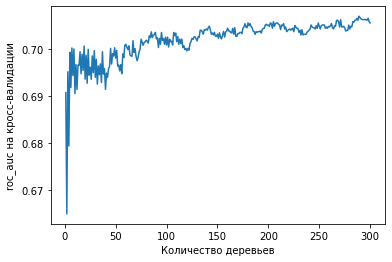

In [58]:
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm
from sklearn.metrics import roc_auc_score as roc_auc
from sklearn.model_selection import train_test_split

# Разбиваем данные на тренировочные и тестовые
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) 
# Обучаем случайный лес с большим количеством деревьев
rf = RandomForestClassifier(n_estimators=300)
rf.fit(X_train, y_train)

scores = []
# Для каждого количества деревьев
for i in tqdm(range(1, 301)):
    # Создаём новый случайный лес с i деревьями, взятыми из обученного леса
    rf_subset = RandomForestClassifier(n_estimators=i)
    rf_subset.estimators_ = rf.estimators_[:i]

    # Из-за того, что мы создали новый объект случайного леса, у него не заданы некоторые параметры предыдущего. Поэтому зададим, чтобы прокатило
    rf_subset.n_classes_ = rf.n_classes_
    rf_subset.classes_ = rf.classes_
    rf_subset.n_outputs_ = rf.n_outputs_
    
    # Оценим качество модели на кросс-валидации
    score = roc_auc(y_test, rf_subset.predict(X_test))
    scores.append(score)

# Выведем график зависимости качества от количества деревьев
plt.plot(range(1, 301), scores)
plt.xlabel('Количество деревьев')
plt.ylabel('roc_auc на кросс-валидации')
plt.show()

In [59]:
# Найдём количество деревьев, при котором roc_auc на кросс-валидации максимально
max_score = max(scores)
max_score_index = scores.index(max_score) + 1  # +1, потому что индексация начинается с 0
print(f"Максимальное значение roc_auc: {max_score}, достигается при количестве деревьев: {max_score_index}")

Максимальное значение roc_auc: 0.7069253381936367, достигается при количестве деревьев: 289


In [60]:
# В дальнейшем использую 143 дерева, потому что тут кол-во зависит от рандома, и у меня вышло 143 в предыдущем случае, а каждый раз менять количество деревьев очень затратно по времени
print('Cross Validation средний accuracy:', cross_val_score(RandomForestClassifier(n_estimators=143), X, y, cv = 5, scoring='accuracy').mean())

Cross Validation средний accuracy: 0.797940697295536


**Задание 4 (0.5 балла)** Подберём число деревьев (*n_estimators*) в алгоритме GradientBoosting. Мы знаем, что ошибка бустинга на тестовых данных, как правило, имеет U-образную форму, то есть сначала уменьшается, а при достижении некоторого числа деревьев начинает расти. Нарисуйте график ошибки в зависимости от числа деревьев. Подберите n_estimators, соответствующий минимуму ошибки.

  0%|          | 0/1000 [00:00<?, ?it/s]/Users/yanik/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
/Users/yanik/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
/Users/yanik/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
/Users/yanik/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
/Users/yanik/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
/User

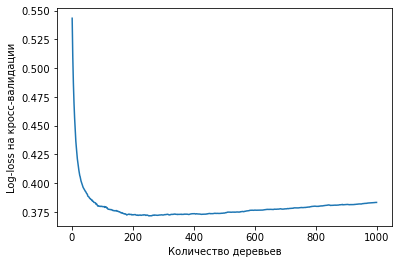

In [61]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import log_loss
# Обучаем градиентный бустинг с большим количеством деревьев
gb = GradientBoostingClassifier(n_estimators=1000)
gb.fit(X_train, y_train)

log_losses = []
# Для каждого количества деревьев
for i in tqdm(range(1, 1001)):
    # Создаём новый градиентный бустинг с i деревьями, взятыми из обученного алгоритма
    gb_subset = GradientBoostingClassifier(n_estimators=i)
    gb_subset.estimators_ = gb.estimators_[:i]

    # Из-за того, что мы создали новый объект градиентного, у него не заданы некоторые параметры предыдущего. Поэтому зададим, чтобы прокатило
    gb_subset.n_classes_ = gb.n_classes_
    gb_subset.classes_ = gb.classes_
    gb_subset.init_ = gb.init_
    gb_subset._loss = gb._loss
     # Оценим качество модели на кросс-валидации
    log_loss_value = log_loss(y_test, gb_subset.predict_proba(X_test))
    log_losses.append(log_loss_value)

# Выведем график зависимости log-loss от количества деревьев
plt.plot(range(1, 1001), log_losses)
plt.xlabel('Количество деревьев')
plt.ylabel('Log-loss на кросс-валидации')
plt.show()

In [62]:
# Найдём количество деревьев, при котором ошибка на кросс-валидации минимальна
min_log = min(log_losses)
min_log_index = log_losses.index(min_log) + 1  # +1, потому что индексация начинается с 0
print(f"Минимальное значение log-loss: {min_log}, достигается при количестве деревьев: {min_log_index}")

Минимальное значение log-loss: 0.3715178041174572, достигается при количестве деревьев: 254


In [63]:
gb_best = GradientBoostingClassifier(n_estimators=254)
print('Cross Validation средний roc_auc:', cross_val_score(gb_best, X, y, cv = 5, scoring='roc_auc').mean())
print('Cross Validation средний accuracy:', cross_val_score(gb_best, X, y, cv = 5, scoring='accuracy').mean())

Cross Validation средний roc_auc: 0.8658775575791727
Cross Validation средний accuracy: 0.8349517450431604


При обучении алгоритмов стоит обращать внимание не только на качество, но и каким образом они работают с данными. В этой задаче получилось так, что некоторые из используемых алгоритмов чувствительны к масштабу признаков. Чтобы убедиться, что это как-то могло повлиять на качество давайте посмотрим на сами признаки.

**Задание 5 (0.5 балла)** Постройте гистограммы для признаков *age*, *fnlwgt*, *capital-gain*. Глядя на получившиеся графики в чем заключается особенность данных? На какие алгоритмы это может повлиять? Может ли масшитабирование повлиять на работу этих алгоритмов?

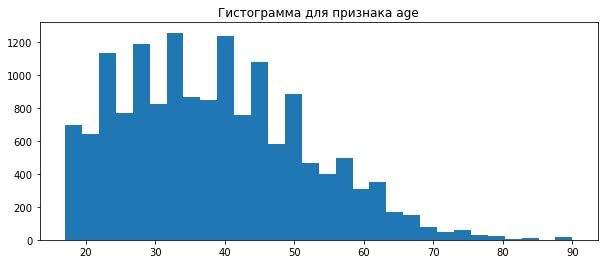

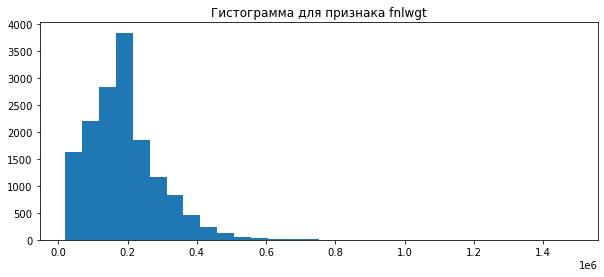

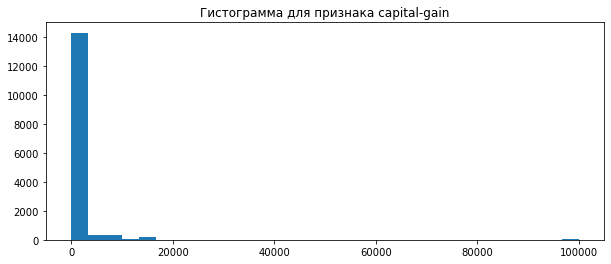

In [64]:
# Построим гистограммы для каждого из признаков
for feature in ['age', 'fnlwgt', 'capital-gain']:
    plt.figure(figsize=(10, 4))
    plt.hist(data_continuous[feature], bins=30)
    plt.title(f'Гистограмма для признака {feature}')
    plt.show()

Особенность данных:
Age:
Распределение похоже на хи-квадрат, однако некоторых возрастов по всей длине гистограммы в определенных возрастных когортах встречается больше, чем других. Из-за этого появляются так называемые шипы. Ну и конечно имеется длинный хвост
fnlwgt:
Распределение похоже на геометрическое. Также присутствует длинный хвост
capital-gain:
Распределение сконцентрировано по большей части у нуля, имеются выбросы в хвосте

Может ли повлиять на работу алгоритмов: 
Да, может:
Во-первых, во всех этих переменных имеются хвосты с выбросами, которые могут повлиять по сути на любой алгоритм МО. Также, в частности, линейные модели предполагают, что данные имеют нормальное распределение. Если это предположение нарушится, модели могут работать неэффективно. Методы, работающие на основе расстояния также могут исказиться из-за расстояния выбросов от основной выборки и привести к неверной классификации.

Может ли масштабирование повлиять на работу таких алгоритмов:
Конечно может, например, если отмасштабировать к нормальному распределению для линейных моделей или отмасштабировать по минимуму и максимуму. А, ну и это оказывается ниже и описано :)


Масштабирование признаков можно выполнить, например, одним из следующих способов способами:
 - $x_{new} = \dfrac{x - \mu}{\sigma}$, где $\mu, \sigma$ — среднее и стандартное отклонение значения признака по всей выборке (см. функцию [scale](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.scale.html))
 - $x_{new} = \dfrac{x - x_{min}}{x_{max} - x_{min}}$, где $[x_{min}, x_{max}]$ — минимальный интервал значений признака

Похожие схемы масштабирования приведены в классах [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) и [MinMaxScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler).
 
**Задание 6 (1 балл)** Масштабируйте все вещественные признаки одним из указанных способов и подберите оптимальные значения гиперпараметров аналогично пункту выше.

In [65]:
from sklearn.preprocessing import StandardScaler

# Отскалируем признаки и создадим новые датасеты для train и test
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)


Подозреваю, что про пункт выше - это про задания по каждой из моделей, а не про гистограммы признаков :) 

Ну что ж, сделаем это снова)

In [66]:
# KNN
param_grid_KNN = {'n_neighbors':np.arange(1, 30)} # # задаём сетку параметра
              
knnmodel = KNeighborsClassifier() # создаем модель

grid_search = GridSearchCV(knnmodel, param_grid_KNN, cv=5, scoring='roc_auc') # для валидации был выбран f1, так как он учитывает и полноту, и точность. При этом он не учитывает True Negative, что в данном случае нам и не особо важно. Если компании нужно хорошо идентифицировать богатых, то ей может быть важно минимизировать False Negative и False Positive, чтобы найти всех богатых и не тратить время на бедных. Однако конечно выбор метрики зависит от целей. Тут цели туманны, поэтому выбрал такую)

grid_search.fit(X_scaled, y) # обучение модели с помощью GridSearchCV который подобрали выше

print("Наилучший параметр:", grid_search.best_params_) # лучший параметр


best_model_KNN_scaled = grid_search.best_estimator_ # лучшая модель

Наилучший параметр: {'n_neighbors': 29}


In [67]:
print('Cross Validation средний roc_auc:', cross_val_score(best_model_KNN_scaled, X_scaled, y, cv = 5, scoring='roc_auc').mean())
print('Cross Validation средний accuracy:', cross_val_score(best_model_KNN_scaled, X_scaled, y, cv = 5, scoring='accuracy').mean())

Cross Validation средний roc_auc: 0.8325545929746724
Cross Validation средний accuracy: 0.8111032570105807


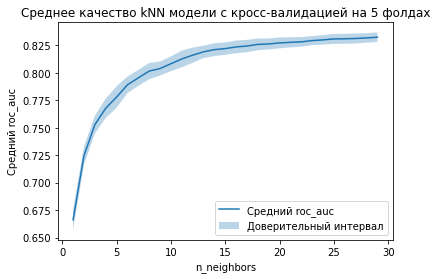

In [68]:
# Строим график для KNN

n_neighbors_values = np.arange(1, 30) # значения параметра n_neighbors

# Создаём пустые списки для средних значений и стандартных отклонений
mean_scores = []
std_scores = []

# Вычисляем средние значения и стандартные отклонения
for n_neighbors in n_neighbors_values:
    knn_model = KNeighborsClassifier(n_neighbors=n_neighbors)
    scores = cross_val_score(knn_model, X_scaled, y, cv=5, scoring='roc_auc')
    mean_scores.append(scores.mean())
    std_scores.append(scores.std())

# Подсчитываем границы доверительного интервала
lower_bound = np.array(mean_scores) - np.array(std_scores)
upper_bound = np.array(mean_scores) + np.array(std_scores)

# Строим график
plt.plot(n_neighbors_values, mean_scores, label='Средний roc_auc')
plt.fill_between(n_neighbors_values, lower_bound, upper_bound, alpha=0.3, label='Доверительный интервал')
plt.xlabel('n_neighbors')
plt.ylabel('Средний roc_auc')
plt.title('Среднее качество kNN модели с кросс-валидацией на 5 фолдах')
plt.legend()
plt.show()


In [69]:
# SGD
param_grid_SGD = {'loss': ['modified_huber', 'epsilon_insensitive', 'squared_epsilon_insensitive', 'hinge', 'huber', 'perceptron', 'squared_hinge', 'log_loss', 'squared_error']} # сетка параметров для SGD
              
sgdmodel = SGDClassifier(max_iter=10000) # создаем модель, max_iter=10000, чтобы не было ошибки, что не успело сойтись решение до определенной итерации

grid_search = GridSearchCV(sgdmodel, param_grid_SGD, cv=5, scoring='roc_auc') 

grid_search.fit(X_scaled, y) # обучение модели с помощью GridSearchCV который подобрали выше

print("Наилучший параметр:", grid_search.best_params_) # лучший параметр


best_model_sgd_scaled = grid_search.best_estimator_ # лучшая модель

Наилучший параметр: {'loss': 'log_loss'}


In [92]:
print('Cross Validation средний roc_auc:', cross_val_score(best_model_sgd_scaled, X_scaled, y, cv = 5, scoring='roc_auc').mean())
print('Cross Validation средний accuracy:', cross_val_score(best_model_sgd_scaled, X_scaled, y, cv = 5, scoring='accuracy').mean())

Cross Validation средний roc_auc: 0.8216631871484525
Cross Validation средний accuracy: 0.7993740918696262


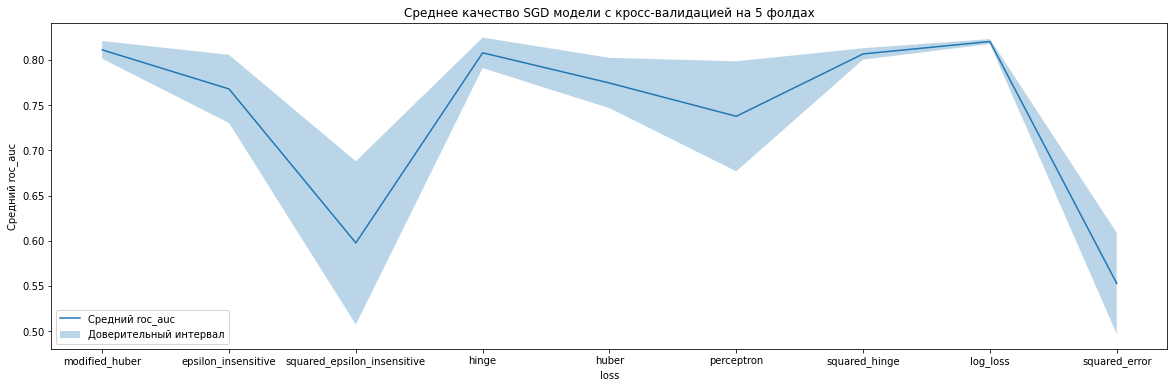

In [71]:
# Строим график для SGD

loss_values = ['modified_huber', 'epsilon_insensitive', 'squared_epsilon_insensitive', 'hinge', 'huber', 'perceptron', 'squared_hinge', 'log_loss', 'squared_error'] # значения параметра loss

# Создаём пустые списки для средних значений и стандартных отклонений
mean_scores = []
std_scores = []

# Вычисляем средние значения и стандартные отклонения
for loss in loss_values:
    sgd_model = SGDClassifier(loss=loss)
    scores = cross_val_score(sgd_model, X_scaled, y, cv=5, scoring='roc_auc')
    mean_scores.append(scores.mean())
    std_scores.append(scores.std())

# Подсчитываем границы доверительного интервала
lower_bound = np.array(mean_scores) - np.array(std_scores)
upper_bound = np.array(mean_scores) + np.array(std_scores)

# Строим график
plt.figure(figsize=(20, 6))
plt.plot(loss_values, mean_scores, label='Средний roc_auc')
plt.fill_between(loss_values, lower_bound, upper_bound, alpha=0.3, label='Доверительный интервал')
plt.xlabel('loss')
plt.ylabel('Средний roc_auc')
plt.title('Среднее качество SGD модели с кросс-валидацией на 5 фолдах')
plt.legend()
plt.show()

In [72]:
# Decision Tree
param_grid_tree = {'max_depth':np.arange(1, 100)} # задаём сетку параметра
              
treemodel = DecisionTreeClassifier() # создаем модель

grid_search = GridSearchCV(treemodel, param_grid_tree, cv=5, scoring='roc_auc') 

grid_search.fit(X_scaled, y) # обучение модели с помощью GridSearchCV который подобрали выше

print("Наилучший параметр:", grid_search.best_params_) # лучший параметр


best_model_tree_scaled = grid_search.best_estimator_ # лучшая модель

Наилучший параметр: {'max_depth': 7}


In [73]:
print('Cross Validation средний roc_auc:', cross_val_score(best_model_tree_scaled, X_scaled, y, cv = 5, scoring='roc_auc').mean())
print('Cross Validation средний accuracy:', cross_val_score(best_model_tree_scaled, X_scaled, y, cv = 5, scoring='accuracy').mean())

Cross Validation средний roc_auc: 0.8414034599993642
Cross Validation средний accuracy: 0.8191836405454141


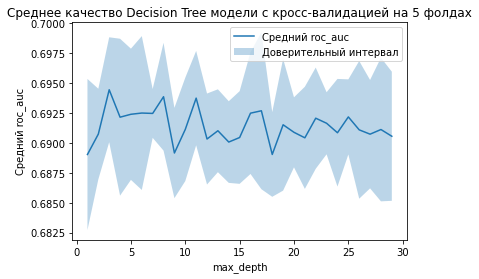

In [74]:
# Строим график для Decision Tree

max_depth_values = np.arange(1, 30) # значения параметра max_depth

# Создаём пустые списки для средних значений и стандартных отклонений
mean_scores = []
std_scores = []

# Вычисляем средние значения и стандартные отклонения
for max_depth in max_depth_values:
    tree_model = DecisionTreeClassifier(max_depth=n_neighbors)
    scores = cross_val_score(tree_model, X_scaled, y, cv=5, scoring='roc_auc')
    mean_scores.append(scores.mean())
    std_scores.append(scores.std())

# Подсчитываем границы доверительного интервала
lower_bound = np.array(mean_scores) - np.array(std_scores)
upper_bound = np.array(mean_scores) + np.array(std_scores)

# Строим график
plt.plot(max_depth_values, mean_scores, label='Средний roc_auc')
plt.fill_between(max_depth_values, lower_bound, upper_bound, alpha=0.3, label='Доверительный интервал')
plt.xlabel('max_depth')
plt.ylabel('Средний roc_auc')
plt.title('Среднее качество Decision Tree модели с кросс-валидацией на 5 фолдах')
plt.legend()
plt.show()

Так как для дальнейших экспериментов в алгоритме случайного леса и градиентного бустинга мы будем использовать фиксированное количество деревьев, которое мы выяили раньше, то для них тестим только на определенном количестве базовых алгоритмво.

In [75]:
rf_scaled = RandomForestClassifier(n_estimators=143)
print('Cross Validation средний roc_auc:', cross_val_score(rf_scaled, X_scaled, y, cv = 5, scoring='roc_auc').mean())
print('Cross Validation средний accuracy:', cross_val_score(rf_scaled, X_scaled, y, cv = 5, scoring='accuracy').mean())

Cross Validation средний roc_auc: 0.8182155334753846
Cross Validation средний accuracy: 0.7995045760749239


Для градиенного бустинга придётся заново посчитать, потому что в cross_val_score есть только neg_log_loss, который почему-то что-то другое считает, поэтому вот:

100%|██████████| 1000/1000 [00:36<00:00, 27.13it/s]


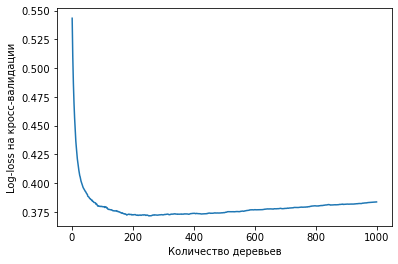

In [76]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import log_loss
# Обучаем градиентный бустинг с большим количеством деревьев
gb = GradientBoostingClassifier(n_estimators=1000)
gb.fit(X_train, y_train)

log_losses = []
# Для каждого количества деревьев
for i in tqdm(range(1, 1001)):
    # Создаём новый градиентный бустинг с i деревьями, взятыми из обученного алгоритма
    gb_subset = GradientBoostingClassifier(n_estimators=i)
    gb_subset.estimators_ = gb.estimators_[:i]

    # Из-за того, что мы создали новый объект градиентного, у него не заданы некоторые параметры предыдущего. Поэтому зададим, чтобы прокатило
    gb_subset.n_classes_ = gb.n_classes_
    gb_subset.classes_ = gb.classes_
    gb_subset.init_ = gb.init_
    gb_subset._loss = gb._loss
     # Оценим качество модели на кросс-валидации
    log_loss_value = log_loss(y_test, gb_subset.predict_proba(X_test))
    log_losses.append(log_loss_value)

# Выведем график зависимости log-loss от количества деревьев
plt.plot(range(1, 1001), log_losses)
plt.xlabel('Количество деревьев')
plt.ylabel('Log-loss на кросс-валидации')
plt.show()

In [77]:
# Найдём количество деревьев, при котором ошибка на кросс-валидации минимальна
min_log = min(log_losses)
min_log_index = log_losses.index(min_log) + 1  # +1, потому что индексация начинается с 0
print(f"Минимальное значение log-loss: {min_log}, достигается при количестве деревьев: {min_log_index}")

Минимальное значение log-loss: 0.3716548553155499, достигается при количестве деревьев: 254


In [78]:
gb_best = GradientBoostingClassifier(n_estimators=254)
print('Cross Validation средний roc_auc:', cross_val_score(gb_best, X_scaled, y, cv = 5, scoring='roc_auc').mean())
print('Cross Validation средний accuracy:', cross_val_score(gb_best, X_scaled, y, cv = 5, scoring='accuracy').mean())

Cross Validation средний roc_auc: 0.8658651236083003
Cross Validation средний accuracy: 0.8348214094289539


Изменилось ли качество у некоторых алгоритмов?

У KNN качество стало заметно лучше. Поменялась зависимость: теперь при росте n_neighbors качество модели растёт и выходит на плато в определенный момент, а roc_auc вырос примерно на 0.18, что очень неплохо. Accuracy вырос на 0.04

У SGD также выросло качество roc_auc у самых хороших функций потерь примерно на 0.20, а Accuracy вообще на 0.04

У Decision Tree незначительное изменение и оно может поменяться на других итерациях, поэтому в случае с этим алгоритмом особо ничего не поменялось

На Random Forest скалирование тоже особо не повлияло. 

На Gradient Boosting скалирование не оказало заметного влияния.

**Задание 7 (1.25 балла)** Теперь сделайте перебор нескольких гиперпараметров по сетке и найдите оптимальные комбинации (лучшее среднее значение качества) для каждого алгоритма в данном случае: 
 - KNN — число соседей (*n_neighbors*) и метрика (*metric*)
 - DecisonTree — глубина дерева (*max_depth*) и критерий разбиения (*criterion*)
 - RandomForest — критерий разбиения в деревьях (*criterion*) и *max_features* (при фиксированном количестве деревьев, найденном ранее)
 - GradientBoosting — критерий разбиения в деревьях (*criterion*) и *max_features* (при фиксированном количестве деревьев, найденном ранее)
 - SGDClassifier — оптимизируемая функция (*loss*) и *penalty*
 
Обратите внимание, что эта операция может быть ресурсо- и трудоемкой. Как оптимизировать подбор параметров по сетке сказано в разделе "Подбор гиперпараметров модели"

In [79]:
# KNN
param_grid_KNN = {'n_neighbors':np.arange(1, 30),
                    'metric': ['jaccard', 'rogerstanimoto', 'yule', 'haversine', 'dice', 'russellrao', 'euclidean', 'braycurtis', 'sqeuclidean', 'sokalsneath', 'correlation', 'chebyshev', 'l2', 'p', 'canberra', 'pyfunc', 'matching', 'infinity', 'minkowski', 'cosine', 'cityblock', 'seuclidean', 'sokalmichener', 'l1', 'mahalanobis', 'hamming', 'nan_euclidean', 'kulsinski', 'manhattan']} # задаём сетку параметров
              
knnmodel = KNeighborsClassifier() # создаем модель

grid_search = GridSearchCV(knnmodel, param_grid_KNN, cv=5, scoring='roc_auc') # для валидации был выбран f1, так как он учитывает и полноту, и точность. При этом он не учитывает True Negative, что в данном случае нам и не особо важно. Если компании нужно хорошо идентифицировать богатых, то ей может быть важно минимизировать False Negative и False Positive, чтобы найти всех богатых и не тратить время на бедных. Однако конечно выбор метрики зависит от целей. Тут цели туманны, поэтому выбрал такую)

grid_search.fit(X_scaled, y) # обучение модели с помощью GridSearchCV который подобрали выше

print("Наилучший параметр:", grid_search.best_params_) # лучший параметр


best_model_KNN = grid_search.best_estimator_ # лучшая модель

/Users/yanik/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric yule
  warnings.warn(msg, DataConversionWarning)
/Users/yanik/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric yule
  warnings.warn(msg, DataConversionWarning)
/Users/yanik/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric yule
  warnings.warn(msg, DataConversionWarning)
/Users/yanik/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric yule
  warnings.warn(msg, DataConversionWarning)
/Users/yanik/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric yule
  warnings.warn(msg, DataConversio

Наилучший параметр: {'metric': 'braycurtis', 'n_neighbors': 29}


/Users/yanik/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
580 fits failed out of a total of 4205.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
145 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/yanik/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/yanik/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/yanik/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py", line 228, in fit
    return

In [80]:
print('Cross Validation средний roc_auc:', cross_val_score(best_model_KNN, X_scaled, y, cv = 5, scoring='roc_auc').mean())
print('Cross Validation средний accuracy:', cross_val_score(best_model_KNN, X_scaled, y, cv = 5, scoring='accuracy').mean())

Cross Validation средний roc_auc: 0.834700506529793
Cross Validation средний accuracy: 0.8114942213986029


In [81]:
# SGD
param_grid_SGD = {'loss': ['modified_huber', 'epsilon_insensitive', 'squared_epsilon_insensitive', 'hinge', 'huber', 'perceptron', 'squared_hinge', 'log_loss', 'squared_error'],
                    'penalty': ['l2', 'l1', 'elasticnet', None] } # сетка параметров для SGD
              
sgdmodel = SGDClassifier(max_iter=10000) # создаем модель, max_iter=10000, чтобы не было ошибки, что не успело сойтись решение до определенной итерации

grid_search = GridSearchCV(sgdmodel, param_grid_SGD, cv=5, scoring='roc_auc') 

grid_search.fit(X_scaled, y) # обучение модели с помощью GridSearchCV который подобрали выше

print("Наилучший параметр:", grid_search.best_params_) # лучший параметр


best_model_sgd_scaled = grid_search.best_estimator_ # лучшая модель

Наилучший параметр: {'loss': 'log_loss', 'penalty': 'elasticnet'}


In [82]:
print('Cross Validation средний roc_auc:', cross_val_score(best_model_sgd_scaled, X_scaled, y, cv = 5, scoring='roc_auc').mean())
print('Cross Validation средний accuracy:', cross_val_score(best_model_sgd_scaled, X_scaled, y, cv = 5, scoring='accuracy').mean())

Cross Validation средний roc_auc: 0.8210783806904519
Cross Validation средний accuracy: 0.8017852370505517


In [83]:
# Decision Tree
param_grid_tree = {'max_depth':np.arange(1, 100), 
                    'criterion': ['gini', 'entropy', 'log_loss']} # задаём сетку параметра
              
treemodel = DecisionTreeClassifier() # создаем модель

grid_search = GridSearchCV(treemodel, param_grid_tree, cv=5, scoring='roc_auc') # для валидации был выбран f1, так как он учитывает и полноту, и точность. При этом он не учитывает True Negative, что в данном случае нам и не особо важно. Если компании нужно хорошо идентифицировать богатых, то ей может быть важно минимизировать False Negative и False Positive, чтобы найти всех богатых и не тратить время на бедных. Однако конечно выбор метрики зависит от целей. Тут цели туманны, поэтому выбрал такую)

grid_search.fit(X_scaled, y) # обучение модели с помощью GridSearchCV который подобрали выше

print("Наилучший параметр:", grid_search.best_params_) # лучший параметр


best_model_tree_scaled = grid_search.best_estimator_ # лучшая модель

Наилучший параметр: {'criterion': 'log_loss', 'max_depth': 8}


In [84]:
print('Cross Validation средний roc_auc:', cross_val_score(best_model_tree_scaled, X_scaled, y, cv = 5, scoring='roc_auc').mean())
print('Cross Validation средний accuracy:', cross_val_score(best_model_tree_scaled, X_scaled, y, cv = 5, scoring='accuracy').mean())

Cross Validation средний roc_auc: 0.8431941906797482
Cross Validation средний accuracy: 0.8187926973846906


In [85]:
# Random Forest
n_features = X_scaled.shape[1] # количество признаков
param_grid_rf = {'max_features':np.arange(1, n_features+1), 
                    'criterion': ['gini', 'entropy', 'log_loss'],
                    'n_estimators': [143]} # задаём сетку параметров

rfmodel = RandomForestClassifier() # создаем модель

grid_search = GridSearchCV(rfmodel, param_grid_rf, cv=5, scoring='roc_auc')

grid_search.fit(X_scaled, y) # обучение модели с помощью GridSearchCV который подобрали выше

print("Наилучшие параметры:", grid_search.best_params_) # лучший параметр

best_model_rf_scaled = grid_search.best_estimator_ # лучшая модель

Наилучшие параметры: {'criterion': 'entropy', 'max_features': 5, 'n_estimators': 143}


In [86]:
print('Cross Validation средний roc_auc:', cross_val_score(best_model_rf_scaled, X_scaled, y, cv = 5, scoring='roc_auc').mean())
print('Cross Validation средний accuracy:', cross_val_score(best_model_rf_scaled, X_scaled, y, cv = 5, scoring='accuracy').mean())

Cross Validation средний roc_auc: 0.8215010573917014
Cross Validation средний accuracy: 0.8013295506286996


In [87]:
# Gradient Boosting
n_features = X_scaled.shape[1] # количество признаков
param_grid_gb = {'max_features':np.arange(1, n_features+1),  
                    'criterion': ['friedman_mse', 'squared_error'],
                    'n_estimators': [254]} # задаём сетку параметров

gbmodel = GradientBoostingClassifier() # создаем модель

grid_search = GridSearchCV(gbmodel, param_grid_gb, cv=5, scoring='neg_log_loss') # для валидации был выбран f1, так как он учитывает и полноту, и точность. При этом он не учитывает True Negative, что в данном случае нам и не особо важно. Если компании нужно хорошо идентифицировать богатых, то ей может быть важно минимизировать False Negative и False Positive, чтобы найти всех богатых и не тратить время на бедных. Однако конечно выбор метрики зависит от целей. Тут цели туманны, поэтому выбрал такую)

grid_search.fit(X_scaled, y) # обучение модели с помощью GridSearchCV который подобрали выше

print("Наилучшие параметры:", grid_search.best_params_) # лучший параметр

best_model_gb_scaled = grid_search.best_estimator_ # лучшая модель

Наилучшие параметры: {'criterion': 'squared_error', 'max_features': 5, 'n_estimators': 254}


In [88]:
print('Cross Validation средний roc_auc:', cross_val_score(best_model_gb_scaled, X_scaled, y, cv = 5, scoring='roc_auc').mean())
print('Cross Validation средний accuracy:', cross_val_score(best_model_gb_scaled, X_scaled, y, cv = 5, scoring='accuracy').mean())

Cross Validation средний roc_auc: 0.8661614271908796
Cross Validation средний accuracy: 0.8346911587239422


Какой из алгоритмов имеет наилучшее качество? 

Наилучшее качество выдаёт Gradient Boosting, что не особо удивительно: это самый мощный алгоритм из представленных в плане нивелирования ошибки предсказания из-за того, что каждый последующий базовый алгоритм пытается предсказать ошибку предыдущего.



**Задание 8 (0.5 балла)** Сравните алгоритмы с точки зрения времени обучения. Обучение какого из алгоритмов работает дольше всего и, как вы думаете, почему?

In [89]:
import time

# KNN
start_time = time.time()
best_model_KNN.fit(X_scaled, y)
end_time = time.time()
knn_training_time = end_time - start_time
print("KNN время обучения:", knn_training_time)

# SGD
start_time = time.time()
best_model_sgd_scaled.fit(X_scaled, y)
end_time = time.time()
sgd_training_time = end_time - start_time
print("SGD время обучения:", sgd_training_time)

# Decision Tree
start_time = time.time()
best_model_tree_scaled.fit(X_scaled, y)
end_time = time.time()
tree_training_time = end_time - start_time
print("Decision Tree время обучения:", tree_training_time)

# Random Forest
start_time = time.time()
best_model_rf_scaled.fit(X_scaled, y)
end_time = time.time()
rf_training_time = end_time - start_time
print("Random Forest время обучения:", rf_training_time)

# Gradient Boosting
start_time = time.time()
best_model_gb_scaled.fit(X_scaled, y)
end_time = time.time()
gb_training_time = end_time - start_time
print("Gradient Boosting время обучения:", gb_training_time)


KNN время обучения: 0.009199142456054688
SGD время обучения: 0.0465700626373291
Decision Tree время обучения: 0.04066896438598633
Random Forest время обучения: 5.639305830001831
Gradient Boosting время обучения: 2.87579083442688


Как видно, Gradient Boosting обучается на наилучших параметрах дольше всех, затрачивая 3.19 секунды. В целом, очевидно, почему он затрачивает больше всего времени. Данному алгоритму для завершения необходимо обучить 254 базовых алгоритма (254 обычных дерева), на которые требуется больше вычислительной мощности, чем на остальные алгоритмы. 

## Добавление категориальных признаков в модели

Пока мы не использовали нечисловые признаки, которые есть в датасете. Давайте посмотрим, правильно ли мы сделали и увеличится ли качество моделей после добавлениях этих признаков. 

**Задание 9 (0.5 балла)** Преобразуйте все категориальные признаки с помощью метода one-hot-encoding (например, это можно сделать с помощью функции [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html), [pandas.get_dummies](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html) или [DictVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html) из sklearn).

In [12]:
from sklearn.preprocessing import OneHotEncoder
onehotencoder = OneHotEncoder()
cat_data = data.drop(['age', 'fnlwgt', 'capital-gain', 'capital-loss', 'hours-per-week'], axis=1)
cat_data = onehotencoder.fit_transform(cat_data).toarray()
cat_data = pd.DataFrame(cat_data)
cat_data.shape

(15347, 75)

**Задание 10 (0.5 балла)** Добавьте к масштабированным вещественным признакам закодированные категориальные и обучите алгоритмы с наилучшими гиперпараметрами из предыдущего пункта. Дало ли добавление новых признаков прирост качества? Измеряйте качество как и раньше используя 5-Fold CV. Для этого удобно воспользоваться функцией [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html).

In [13]:
# Для того, чтобы нормально объединить, нужно сбросить индексы строк, потому что иначе они будут не совпадать из-за того, что мы удаляли строки из датасета, а при создании data_continuous они создались заново. Из-за этого data_continuous не будет совпадать с cat_data, так как у них будут разные индексы строк. Поэтому сбрасываем индексы строк и объединяем датасеты
data_continuous_reset = data_continuous.reset_index(drop=True)
cat_data_reset = cat_data.reset_index(drop=True)
data_merged = pd.concat([data_continuous_reset, cat_data_reset], axis=1)

print(data_merged.shape)

X_merged = data_merged.drop(['Target'], axis=1)
X_merged.columns = X_merged.columns.astype(str)

(15347, 82)


In [93]:
# KNN
score = cross_val_score(best_model_KNN, X_merged, y, cv=5, scoring='roc_auc')
print("KNN средняя roc_auc на кросс-валидации: ", score.mean())
print("KNN средняя accuracy на кросс-валидации: ", cross_val_score(best_model_KNN, X_merged, y, cv=5, scoring='accuracy').mean() )

# SGD
score = cross_val_score(best_model_sgd_scaled, X_merged, y, cv=5, scoring='roc_auc')
print("\nSGD средняя roc_auc на кросс-валидации: ", score.mean())
print("SGD средняя accuracy на кросс-валидации: ", cross_val_score(best_model_sgd_scaled, X_merged, y, cv=5, scoring='accuracy').mean())

# Decision Tree
score = cross_val_score(best_model_tree_scaled, X_merged, y, cv=5, scoring='roc_auc')
print("\nDecision Tree средняя roc_auc на кросс-валидации: ", score.mean())
print("Decision Tree средняя accuracy на кросс-валидации: ", cross_val_score(best_model_tree_scaled, X_merged, y, cv=5, scoring='accuracy').mean())

# Random Forest
score = cross_val_score(best_model_rf_scaled, X_merged, y, cv=5, scoring='roc_auc')
print("\nRandom Forest средняя roc_auc на кросс-валидации: ", score.mean())
print("Random Forest средняя accuracy на кросс-валидации: ", cross_val_score(best_model_rf_scaled, X_merged, y, cv=5, scoring='accuracy').mean())

# Gradient Boosting
score = cross_val_score(best_model_gb_scaled, X_merged, y, cv=5, scoring='roc_auc')
print("\nGradient Boosting средняя roc_auc на кросс-валидации: ", score.mean())
print("Gradient Boosting средняя accuracy на кросс-валидации: ", cross_val_score(best_model_gb_scaled, X_merged, y, cv=5, scoring='accuracy').mean())

KNN средняя roc_auc на кросс-валидации:  0.6367001255949838
KNN средняя accuracy на кросс-валидации:  0.7804131681424946

SGD средняя roc_auc на кросс-валидации:  0.6126136739914336
SGD средняя accuracy на кросс-валидации:  0.7743530503097593

Decision Tree средняя roc_auc на кросс-валидации:  1.0
Decision Tree средняя accuracy на кросс-валидации:  1.0

Random Forest средняя roc_auc на кросс-валидации:  1.0
Random Forest средняя accuracy на кросс-валидации:  1.0

Gradient Boosting средняя roc_auc на кросс-валидации:  1.0
Gradient Boosting средняя accuracy на кросс-валидации:  1.0


Отличается ли теперь наилучший классификатор от наилучшего в предыдущем пункте?

Наилучший классификатор всё так же Gradient Boosting, однако Decision Tree и  Random Forest выдают ровно такой же roc_auc, то есть асболютно правильно классифицируют все объекты. 
Остальные модели же стали классифицировать хуже. Подозреваю, что это из-за того, что стало больше нелинейных взаимосвязей, которые линейные модели не идентифицируют.

## Поиск новых полезных признаков

**Задание 11 (1.25 балла).** Попробуем улучшить качество модели, добавив в неё новые информативные признаки. Поступим так же, как действовали на [семинаре](https://github.com/Murcha1990/ML_Econom_2021-2022/blob/main/Семинары/Семинар%207/Seminar7.ipynb):
* добавьте к модели полиномиальных признаков степени 2 (для создания полиномиальных признаков используйте только исходные числовые признаки)
* затем снизьте размерность с помощью:
a) фильтрационных методов
b) жадного отбора признаков (RFE)
с) встроенного в модель метода отбора признаков.

Для каждого пункта выше выберите один метод и подберите для него оптимальные гиперпараметры, а также количество финальных признаков (по кросс-валидации).

* Затем можно добавить к модели закодированные в предыдущем пункте категориальные признаки.

Позволил ли этот подход улучшить качество моделей? 

In [14]:
from sklearn.preprocessing import PolynomialFeatures

# Добавим полиномиальные признаки к числовым
poly = PolynomialFeatures(2)
data_poly = poly.fit_transform(data_continuous_reset)
y = data['Target']

Так как исследуя все функции потерь, мы и до завтрашнего дня не управимся с перебором, возьмём самые удачные функции в предыдущих экспериментах: modified_huber, hinge, perceptron, squared_hinge, log_loss, huber. У меня реально код всю ночь работал и так и не завершился xD

In [15]:
# a) KBEST фильтрационный метод

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score

# Зададим сетку параметров и для SGD, и для KBest
param_grid = {
    'sgd__learning_rate': ['invscaling', 'adaptive', 'constant'],
    'sgd__eta0': np.arange(0, 1.1,  0.1),
    'sgd__class_weight': ['balanced', None],
    'sgd__loss': ['modified_huber', 'huber', 'perceptron', 'squared_hinge', 'log_loss'],
    'kbest__k': np.arange(1, data_poly.shape[1], 2)
}

# Сделаем пайплайн, который сначала применяет KBest, а затем SGD
kbest_model = Pipeline([
    ('kbest', SelectKBest(score_func=f_classif)),
    ('sgd', SGDClassifier(max_iter=10000))
])

# Создадим объект GridSearchCV с проверкой по 5 фолдам на метрике roc_auc и используем все ядра процессора, чтобы мультипоточно обучать модели
grid = GridSearchCV(kbest_model, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

grid.fit(data_poly, y)

# Получаем лучшие параметры
best_params = grid.best_params_
print("Лучшие параметры:", best_params)



/Users/yanik/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
2700 fits failed out of a total of 29700.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2700 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/yanik/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/yanik/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/yanik/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 420, in fit
    self._final_estimato

Лучшие параметры: {'kbest__k': 1, 'sgd__class_weight': 'balanced', 'sgd__eta0': 0.1, 'sgd__learning_rate': 'invscaling', 'sgd__loss': 'modified_huber'}


/Users/yanik/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 0  7 27 35] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/yanik/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
/Users/yanik/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [16]:
# Теперь применяем лучшие параметры к фильтрации, добавляем категориальные признаки и обучаем модель с лучшими параметрами
kbest_after = SelectKBest(score_func=f_classif, k=best_params['kbest__k'])
best_model_kbest_after = SGDClassifier(learning_rate=best_params['sgd__learning_rate'], eta0=best_params['sgd__eta0'], class_weight=best_params['sgd__class_weight'], loss=best_params['sgd__loss'], max_iter=10000)
data_poly_kbest = kbest_after.fit_transform(data_poly, y)
data_poly_kbest_cat = pd.concat([pd.DataFrame(data_poly_kbest), cat_data.reset_index(drop=True)], axis=1)


# Вычисляем среднее значение roc_auc и accuracy на кросс-валидации
score_roc = cross_val_score(best_model_kbest_after, data_poly_kbest_cat, y, cv=5, scoring='roc_auc').mean()
score_accuracy = cross_val_score(best_model_kbest_after, data_poly_kbest_cat, y, cv=5, scoring='accuracy').mean()
print("SGD средняя roc_auc на кросс-валидации при подборе через Kbest: ", score_roc)
print("SGD средняя accuracy на кросс-валидации при подборе через Kbest: ", score_accuracy)
data_poly = pd.DataFrame(data_poly)
excluded_features = data_poly.columns[kbest_after.get_support() == False]
print('Исключены следующие признаки:', excluded_features)

/Users/yanik/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 0  7 27 35] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/yanik/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
/Users/yanik/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


SGD средняя roc_auc на кросс-валидации при подборе через Kbest:  1.0
SGD средняя accuracy на кросс-валидации при подборе через Kbest:  1.0
Исключены следующие признаки: Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34],
           dtype='int64')


In [17]:
# b) Жадный отбор признаков RFECV
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.feature_selection import RFECV, f_classif

# Зададим сетку параметров для RFECV и для SGD
param_grid = {
    'sgd__learning_rate': ['invscaling'],
    'sgd__eta0': np.arange(0, 1.1, 0.1),
    'sgd__class_weight': ['balanced'],
    'sgd__loss': ['modified_huber', 'perceptron', 'log_loss'],
    'rfecv__min_features_to_select': np.arange(1, data_poly.shape[1], 2)
}

# Сделаем пайплайн, который сначала применяет RFECV, а затем SGD
rfecv_model = Pipeline([
    ('rfecv', RFECV(estimator=SGDClassifier(max_iter=10000), step=1, cv=5, scoring='roc_auc')),
    ('sgd', SGDClassifier(max_iter=10000))
])

# Создадим объект GridSearchCV с проверкой по 5 фолдам на метрике roc_auc
grid = GridSearchCV(rfecv_model, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

grid.fit(data_poly, y)

# Получаем лучшие параметры
best_params_rfecv = grid.best_params_
print("Лучшие параметры:", best_params_rfecv)



/Users/yanik/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
270 fits failed out of a total of 2970.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
270 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/yanik/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/yanik/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/yanik/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 420, in fit
    self._final_estimator.f

Лучшие параметры: {'rfecv__min_features_to_select': 3, 'sgd__class_weight': 'balanced', 'sgd__eta0': 1.0, 'sgd__learning_rate': 'invscaling', 'sgd__loss': 'perceptron'}


Поищем в более узкой сетке, потому что видно, что шаг обучения можно ещё подстроить

In [16]:
# b) Жадный отбор признаков RFECV
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.feature_selection import RFECV, f_classif

# Зададим сетку параметров для RFECV и для SGD
param_grid = {
    'sgd__learning_rate': ['invscaling'],
    'sgd__eta0': np.arange(1, 2, 0.3),
    'sgd__class_weight': ['balanced'],
    'sgd__loss': ['perceptron'],
    'rfecv__min_features_to_select': np.arange(1, 10, 2)
}

# Сделаем пайплайн, который сначала применяет RFECV, а затем SGD
rfecv_model = Pipeline([
    ('rfecv', RFECV(estimator=SGDClassifier(max_iter=10000), step=1, cv=5, scoring='roc_auc')),
    ('sgd', SGDClassifier(max_iter=10000))
])

# Создадим объект GridSearchCV с проверкой по 5 фолдам на метрике roc_auc
grid = GridSearchCV(rfecv_model, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

grid.fit(data_poly, y)

# Получаем лучшие параметры
best_params_rfecv_1 = grid.best_params_
print("Лучшие параметры:", best_params_rfecv_1)

Лучшие параметры: {'rfecv__min_features_to_select': 3, 'sgd__class_weight': 'balanced', 'sgd__eta0': 1.9000000000000001, 'sgd__learning_rate': 'invscaling', 'sgd__loss': 'perceptron'}


In [17]:
from sklearn.model_selection import cross_val_score

# Теперь применяем лучшие параметры к фильтрации, добавляем категориальные признаки и обучаем модель с лучшими параметрами
rfecv = RFECV(estimator=SGDClassifier(), step=1, cv=5, scoring='roc_auc', min_features_to_select=best_params_rfecv_1['rfecv__min_features_to_select'])
data_poly_rfecv = rfecv.fit_transform(data_poly, y)
data_poly_rfecv_cat = pd.concat([pd.DataFrame(data_poly_rfecv), cat_data.reset_index(drop=True)], axis=1)
best_model = SGDClassifier(learning_rate=best_params_rfecv_1['sgd__learning_rate'], eta0=best_params_rfecv_1['sgd__eta0'], class_weight=best_params_rfecv_1['sgd__class_weight'], loss=best_params_rfecv_1['sgd__loss'], max_iter=10000)

# Вычисляем среднее значение roc_auc и accuracy на кросс-валидации
score_roc_auc_rfecv = cross_val_score(best_model, data_poly_rfecv_cat, y, cv=5, scoring='roc_auc').mean()
score_accuracy_rfecv = cross_val_score(best_model, data_poly_rfecv_cat, y, cv=5, scoring='accuracy').mean()
print("SGD средняя roc_auc на кросс-валидации при подборе через RFECV: ", score_roc_auc_rfecv)
print("SGD средняя accuracy на кросс-валидации при подборе через RFECV: ", score_accuracy_rfecv)
data_poly = pd.DataFrame(data_poly)
excluded_features = data_poly.columns[rfecv.get_support() == False]
print('Исключены следующие признаки:', excluded_features)

SGD средняя roc_auc на кросс-валидации при подборе через RFECV:  0.9097571759742854
SGD средняя accuracy на кросс-валидации при подборе через RFECV:  0.94331147982929
Исключены следующие признаки: Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35],
           dtype='int64')


In [18]:
# c) Используем в качестве встроенного в модель метода отбора признаков L1 регуляризацию, так как она может занулять признаки, тем самым их отбирая

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.feature_selection import f_classif

# Зададим сетку параметров для SGD
param_grid_l1 = {
    'learning_rate': ['invscaling', 'adaptive', 'constant'],
    'eta0': np.arange(0.01, 1.1, 0.1),
    'class_weight': ['balanced', None],
    'loss': ['modified_huber', 'huber', 'perceptron', 'squared_hinge', 'log_loss', 'squared_error'],
    'alpha': np.arange(0.01, 1, 0.1),  # добавляем перебор alpha
    'penalty': ['l1']  # используем L1 регуляризацию
}

# Создаем пайплайн с SGDClassifier
sgd_model = SGDClassifier(max_iter=10000)

# Создаем объект GridSearchCV с проверкой по 5 фолдам на метрике roc_auc
grid = GridSearchCV(sgd_model, param_grid_l1, cv=5, scoring='roc_auc', n_jobs=-1)

grid.fit(data_poly, y)

# Получаем лучшие параметры
best_params_l1 = grid.best_params_
print("Лучшие параметры:", best_params_l1)



Лучшие параметры: {'alpha': 0.11, 'class_weight': 'balanced', 'eta0': 0.21000000000000002, 'learning_rate': 'adaptive', 'loss': 'squared_hinge', 'penalty': 'l1'}


In [20]:
# c) Используем в качестве встроенного в модель метода отбора признаков L1 регуляризацию, так как она может занулять признаки, тем самым их отбирая

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.feature_selection import f_classif

# Зададим сетку параметров для SGD
param_grid_l1 = {
       'learning_rate': ['adaptive'],
    'eta0': np.arange(0.15, 0.3, 0.02),
    'class_weight': ['balanced', None],
    'loss': ['modified_huber', 'perceptron', 'squared_hinge'],
    'alpha': np.arange(0.01, 0.1, 0.02),  # добавляем перебор alpha
    'penalty': ['l1']  # используем L1 регуляризацию
}

# Создаем пайплайн с SGDClassifier
sgd_model = SGDClassifier(max_iter=10000)

# Создаем объект GridSearchCV с проверкой по 5 фолдам на метрике roc_auc
grid = GridSearchCV(sgd_model, param_grid_l1, cv=5, scoring='roc_auc', n_jobs=-1)

grid.fit(data_poly, y)

# Получаем лучшие параметры
best_params_l1_1 = grid.best_params_
print("Лучшие параметры:", best_params_l1_1)



Лучшие параметры: {'alpha': 0.03, 'class_weight': 'balanced', 'eta0': 0.15, 'learning_rate': 'adaptive', 'loss': 'perceptron', 'penalty': 'l1'}


In [21]:
# Применяем лучшие параметры к модели, добавляем категориальные признаки и обучаем модель с лучшими параметрами
data_poly_cat_l1 = pd.concat([pd.DataFrame(data_poly), cat_data.reset_index(drop=True)], axis=1)
best_model_after_l1 = SGDClassifier(learning_rate=best_params_l1_1['learning_rate'], eta0=best_params_l1_1['eta0'], class_weight=best_params_l1_1['class_weight'], loss=best_params_l1_1['loss'], alpha=best_params_l1_1['alpha'], penalty='l1', max_iter=10000)

# Вычисляем среднее значение roc_auc и accuracy на кросс-валидации
score_roc_auc_l1 = cross_val_score(best_model_after_l1, data_poly_cat_l1, y, cv=5, scoring='roc_auc').mean()
score_accuracy_l1 = cross_val_score(best_model_after_l1, data_poly_cat_l1, y, cv=5, scoring='accuracy').mean()
print("SGD средняя roc_auc на кросс-валидации при подборе через L1 регуляризацию: ", score_roc_auc_l1)
print("SGD средняя accuracy на кросс-валидации при подборе через L1 регуляризацию: ", score_accuracy_l1)
best_model_after_l1.fit(data_poly_cat_l1, y)
excluded_features = data_poly_cat_l1.columns[best_model_after_l1.coef_[0] == 0]
print('Исключены следующие признаки:', excluded_features)

SGD средняя roc_auc на кросс-валидации при подборе через L1 регуляризацию:  0.7166815047284129
SGD средняя accuracy на кросс-валидации при подборе через L1 регуляризацию:  0.4780130187023115
Исключены следующие признаки: Int64Index([ 0, 27,  0,  1,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
            17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 36,
            37, 38, 39, 40, 42, 44, 45, 46, 47, 48, 50, 51, 52, 53, 54, 55, 56,
            57, 58, 59, 62, 64, 65, 66, 67, 68, 69, 70],
           dtype='int64')


Результаты: 

a) Удалось достичь идеальных показателей предсказывания на нашем датасете для метода стохастического градиентного спуска    
б) Здесь тоже показатели высокое качество roc_auc метрики (0.909) и accuracy около 0.95 на кросс валидации на 5 фолдах  
с) А вот здесь качество не удалось улучшить с помощью традиционной l1 регуляризации, метрики очень посредственные   

## Смешивание моделей

Во всех предыдущих пунктах мы получили много сильных моделей, которые могут быть достаточно разными по своей природе (например, метод ближайших соседей и случайный лес). Часто на практике оказывается возможным увеличить качество предсказания путем смешивания подобных разных моделей. Давайте посмотрим, действительно ли это дает прирост в качестве.

Выберите из построенных моделей двух предыдущих пунктов две, которые дали наибольшее начество на кросс-валидации (обозначим их $clf_1$ и $clf_2$). Далее постройте новый классификатор, ответ которого на некотором объекте $x$ будет выглядеть следующим образом:

$$result(x) = clf_1(x) \cdot \alpha + clf_2(x) \cdot (1 - \alpha)$$

где $\alpha$ — гиперпараметр нового классификатора.

**Задание 12 (1 балл)** Подберите по сетке от 0 до 1 $\alpha$ для этого классификатора с помощью 5-Fold CV и постройте график качества в зависимости от $\alpha$ (аналогичный графику в разделе "Обучение классификаторов и оценка качества"). Дал ли этот подход прирост к качеству по сравнению с моделями ранее?

/Users/yanik/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 0  7 27 35] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/yanik/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
/Users/yanik/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


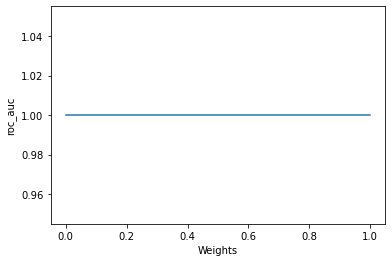

In [25]:
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import GridSearchCV
import pandas as pd
import matplotlib.pyplot as plt


# Выбор лучших признаков
kbestselector = SelectKBest(score_func=f_classif, k=1)
data_poly_kbest = kbestselector.fit_transform(data_poly, y)
data_poly_kbest_cat = pd.concat([pd.DataFrame(data_poly_kbest), cat_data.reset_index(drop=True)], axis=1)

# Определяем базовых классификаторов
best_model_gb_scaled = GradientBoostingClassifier(criterion='squared_error', max_features=5, n_estimators=254)
sgd_kbest = SGDClassifier(learning_rate='invscaling', eta0=0.1, class_weight='balanced', loss='modified_huber', max_iter=10000)


from sklearn.base import BaseEstimator, ClassifierMixin # импортируем базовые классы оценщиков sklearn, чтобы сделать свой оценщик


# Создаем классификатор, который будет усреднять предсказания двух других по их весам и потом выдавать класс с порогом в 0.5, но по сути его можно и сменить. Нам просто необходимо его выбрать, чтобы выдавать класс, а не вероятности
class BlendedClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, clf1, clf2, alpha):
        self.clf1 = clf1
        self.clf2 = clf2
        self.alpha = alpha
    # Обучаем модель
    def fit(self, X, y):
        self.clf1.fit(X, y)
        self.clf2.fit(X, y)
        self.classes_ = np.unique(y)
        return self
    # Предсказываем вероятности
    def predict_proba(self, X):
        proba1 = self.clf1.predict_proba(X)
        proba2 = self.clf2.predict_proba(X)
        return proba1 * self.alpha + proba2 * (1 - self.alpha)
     # Метод predict, который делает предсказания на основе усредненного единого ответа с учетом веса каждого алгоритма
    def predict(self, X):
        average_proba = self.predict_proba(X)
        return (average_proba[:, 1] >= 0.5).astype(int)

# Создание классификатора
blended_clf = BlendedClassifier(best_model_gb_scaled, sgd_kbest, alpha=0.5)

# Подбор параметров
param_grid = {'alpha': np.arange(0, 1.01, 0.01)}
grid = GridSearchCV(blended_clf, param_grid, cv=5, scoring='roc_auc')
grid.fit(data_poly_kbest_cat, y)

# Визуализация результатов
plt.plot(param_grid['alpha'], grid.cv_results_['mean_test_score'])
plt.xlabel('Weights')
plt.ylabel('roc_auc')
plt.show()


In [26]:
best_params_blended = grid.best_params_
print(best_params_blended)

{'alpha': 0.0}


Конечно же мы не можем сказать, стало ли предсказание лучше или хуже, потому что оно по-прежнему идеальное. Необходима какая-то другая выборка из генеральной совокупности, чтобы можно было экстраполировать данные модели на полные данные и понять, насколько хорошо действительно предсказывает алгоритм

## Сравнение построенных моделей

![](http://cdn.shopify.com/s/files/1/0870/1066/files/compare_e8b89647-3cb6-4871-a976-2e36e5987773.png?1750043340268621065)

После того как было построено много моделей хотелось бы сравнить их между собой. Для этого можно построить "ящик с усами" (диаграму размаха). Для этого можно воспользоваться библиотекой [matplotlib](https://matplotlib.org/3.1.0/api/_as_gen/matplotlib.pyplot.boxplot.html) или [seaborn](https://seaborn.pydata.org/generated/seaborn.boxplot.html).

**Задание 13 (1 балл)** Для каждого типа классификатора (kNN, DecisionTree, RandomForest, SGD classifier), а так же смешанной модели выберите тот, которых давал наилучшее качество на кросс-валидации (с учетом подобранных гиперпараметров) и постройте диаграмму размаха (все классификаторы должны быть изображены на одном графике).
 
Сделайте общие итоговые выводы о классификаторах с точки зрения их работы с признаками и сложности самой модели (какие гиперпараметры есть у модели, сильно ли изменение значения гиперпараметра влияет на качество модели).

roc_auc mean score для {'KNeighborsClassifier'} : 0.621089294376239
Accuracy mean score для {'KNeighborsClassifier'} : 0.7741578440706316
roc_auc mean score для {'DecisionTreeClassifier'} : 1.0
Accuracy mean score для {'DecisionTreeClassifier'} : 1.0
roc_auc mean score для {'RandomForestClassifier'} : 1.0
Accuracy mean score для {'RandomForestClassifier'} : 1.0
roc_auc mean score для {'GradientBoostingClassifier'} : 1.0
Accuracy mean score для {'GradientBoostingClassifier'} : 1.0
roc_auc mean score для {'SGDClassifier'} : 1.0
Accuracy mean score для {'SGDClassifier'} : 1.0
roc_auc mean score для {'BlendedClassifier'} : 1.0
Accuracy mean score для {'BlendedClassifier'} : 1.0


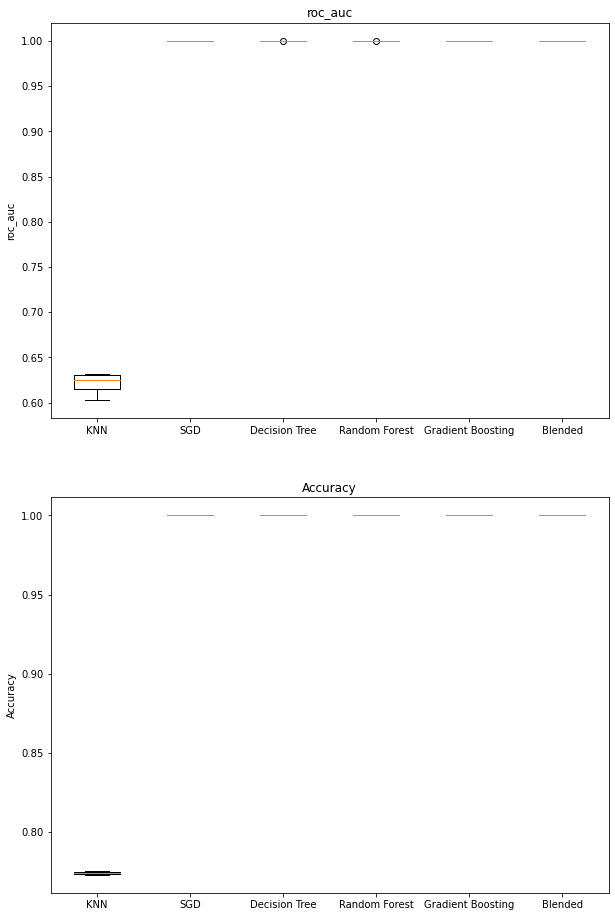

In [27]:
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier


total_data = pd.concat([pd.DataFrame(data_poly), cat_data.reset_index(drop=True)], axis=1)

best_knn_last = KNeighborsClassifier(metric='braycurtis', n_neighbors=21)
best_sgd_last = SGDClassifier(learning_rate='invscaling', eta0=0.001, class_weight='balanced', loss='modified_huber', max_iter=10000)
best_dt_last = DecisionTreeClassifier(criterion='gini', max_depth=3)
best_rf_last = RandomForestClassifier(criterion='log_loss', max_features=2, n_estimators=47)
best_gb_last = GradientBoostingClassifier(criterion='squared_error', max_features= 5, n_estimators=254)
# Список моделей
models = [best_knn_last, best_dt_last, best_rf_last, best_gb_last]

# Список для хранения оценок качества
scores_roc_auc = []
scores_accuracy = []

# Получаем оценки качества для каждой модели, кроме нашего блендера и SGD, потому что там применяется метод отбора признаков Kbest и ему нужно другую дату загонять, и добавляем в список
for model in models:
    score_roc_auc = cross_val_score(model, total_data, y, cv=5, scoring='roc_auc')
    print('roc_auc mean score для', {type(model).__name__}, ':', score_roc_auc.mean())
    scores_roc_auc.append(score_roc_auc)
    score_accuracy = cross_val_score(model, total_data, y, cv=5, scoring='accuracy')
    scores_accuracy.append(score_accuracy)
    print('Accuracy mean score для', {type(model).__name__}, ':', score_accuracy.mean())

# Добавляем оценку качества для блендинга и SGD
models_kbest = [best_sgd_last, blended_clf]
for model in models_kbest:
    score_roc_auc = cross_val_score(model, data_poly_kbest_cat, y, cv=5, scoring='roc_auc')
    print('roc_auc mean score для', {type(model).__name__}, ':', score_roc_auc.mean())
    scores_roc_auc.append(score_roc_auc)
    score_accuracy = cross_val_score(model, data_poly_kbest_cat, y, cv=5, scoring='accuracy')
    scores_accuracy.append(score_accuracy)
    print('Accuracy mean score для', {type(model).__name__}, ':', score_accuracy.mean())

# Строим диаграмму размаха для roc_auc и accuracy
plt.figure(figsize=(10, 16))

plt.subplot(2, 1, 1)
plt.title('roc_auc')
plt.boxplot(scores_roc_auc, labels=['KNN', 'SGD', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 'Blended'])
plt.ylabel('roc_auc')


plt.subplot(2, 1, 2)
plt.boxplot(scores_accuracy, labels=['KNN', 'SGD', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 'Blended'])
plt.title('Accuracy')
plt.ylabel('Accuracy')

plt.show()

Работа с признаками: 
KNN в результате работы оказался самым слабым алгоритмом для этих данных. На него положительно повлияло масштабирование признаков, что ожидаемо, поскольку он работает на расстояниях между точками. Добавление категориальных переменных же повлияло на него отрицательно, хотя на остальные алгоритмы оно повлияло положительно. Это было тоже ожидаемо из-за его специфики.
SGD без сильной настройки тоже показал не очень хорошие результаты. На него так же положительно повлияло масштабирование признаков, а добавление категориальных признаков понизило качество. Однако при фильтрации признаков (по сути убирании почти всех числовых признаков) стохастический град. спуск показал очень хорошие результаты, что замечательно 
Decision Tree сначала показывал 50/50 результаты, но сразу же при добавлении категориальных признаков начал идеально классифицировать 
Random Forest то же самое и здесь. После добавления кат. признаков - идеальная классификация
Gradient Boosting то же самое и здесь. После добавления кат. признаков - идеальная классификация
Blending смысла комментировать не вижу, поскольку он лишь усредняет по весам предсказания выше перечисленных моделей

Сложность модели (все гиперпараметры перечислять думаю будет излишне, поэтому объясню более лаконично, чтобы не читать слишком много того, что и так написано в той же sklearn документации)
KNN в целом имеет немного гиперпараметров, но в самих гиперпараметрах очень много вариаций, что делает его очень долгим для подбора идеальных гиперпараметров. Ну и в них естественно очень большая вариативность в качестве
SGD имеет большое количество гиперпараметров, особенно если подключить регуляризацию и вариативный шаг обучения. Однако на наших данных при тщательном подборе этот метод дал идеальный результат (но очень долгий подбор)
Decision Tree имеет немного гиперпараметров и подбираются они очень быстро. Вариативность естественно будет большая при изменении таких гиперпараметров, как глубина. Однако с добавлением категориальных данных алгоритм стал очень быстро предсказывать с очень быстрым подбором гиперпараметров
Random Forest имеет больше гиперпараметров, поскольку сам состоит из деревьев. Тут уйдёт много времени на подбор оптимального количества базовых алгоритмов, но всё же не так много, как в предыдущих методах.
Gradient Boosting данный алгоритм является одним из самых простеньких среди градиентных бустингов. Естественно, в каком-нибудь cat boost гиперпараметров будет больше и подбор может быть сложнее, но оптимизированнее из-за встроенных методов (как в lightgbm). Данный же алгоритм на наших данных показывает результат аналогичный случайному лесу, но дольше подбирает гиперпараметры и дольше итерируется. Естественно сильно может повлиять на результат глубина базовых алгоритмов и их количество